# Datasets and data loading

The [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) subpackage is an important part of PyTorch for developing neural networks. The `Dataset` class represents a dataset and provides an interface to access the data samples. The `DataLoader` class helps fetch data from the dataset and prepare it for passing to your neural network.

## Case study: ImageNet data

The ImageNet-1000 image classification task has been a huge driver of progress in deep learning. Let's get to know this dataset. 

In [1]:
import os

# Locate the images
image_dir = '/project/rcde/datasets/imagenet/ILSVRC/Data/CLS-LOC/'
os.listdir(image_dir)

['ILSVRC2012_devkit_t12.tar.gz', 'meta.bin', 'test', 'train', 'val']

Imagenet has 1000 different classes. Each class has its own sub-folder (test dataset is organized differently): 

In [2]:
for d in os.listdir(image_dir):
    dir_path = os.path.join(image_dir, d)
    if os.path.isdir(dir_path):  # Check if the item is a directory
        print(d, len(os.listdir(dir_path)))

test 100000
train 1000
val 1000


These classes have uninformative directory names:

In [3]:
os.listdir(image_dir+'train')[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

There's a file that maps from these strange names to human-readable names:

In [4]:
! head -n 5 '/project/rcde/datasets/imagenet/LOC_synset_mapping.txt'

n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark


In [5]:
with open('/project/rcde/datasets/imagenet/LOC_synset_mapping.txt') as f: 
    lines = f.readlines()
    
    # we will need these two dictionaries
    class2label = {l[:9].strip(): l[10:-1].strip() for l in lines}
    class2ix = {l[:9].strip(): ix for ix, l in enumerate(lines)}

Most classes have 1300 training images

In [6]:
for cls in os.listdir(image_dir+'train')[::50]:
    print(class2label[cls], len(os.listdir(f"{image_dir}train/{cls}/")))

tench, Tinca tinca 1300
American alligator, Alligator mississipiensis 1300
black swan, Cygnus atratus 1300
sea lion 1300
Tibetan terrier, chrysanthemum dog 1300
Siberian husky 1300
tiger beetle 1300
ibex, Capra ibex 1300
academic gown, academic robe, judge's robe 1300
bobsled, bobsleigh, bob 1300
cliff dwelling 1300
espresso maker 1136
hook, claw 1300
microphone, mike 1300
paper towel 1300
quilt, comforter, comfort, puff 1300
slot, one-armed bandit 1300
teddy, teddy bear 1300
water tower 1300
orange 1300


Most classes have only 50 validation samples

In [7]:
for cls in os.listdir(image_dir+'val')[::50]:
    print(class2label[cls], len(os.listdir(f"{image_dir}val/{cls}/")))

tench, Tinca tinca 50
American alligator, Alligator mississipiensis 50
black swan, Cygnus atratus 50
sea lion 50
Tibetan terrier, chrysanthemum dog 50
Siberian husky 50
tiger beetle 50
ibex, Capra ibex 50
academic gown, academic robe, judge's robe 50
bobsled, bobsleigh, bob 50
cliff dwelling 50
espresso maker 50
hook, claw 50
microphone, mike 50
paper towel 50
quilt, comforter, comfort, puff 50
slot, one-armed bandit 50
teddy, teddy bear 50
water tower 50
orange 50


Let's look at a a few images

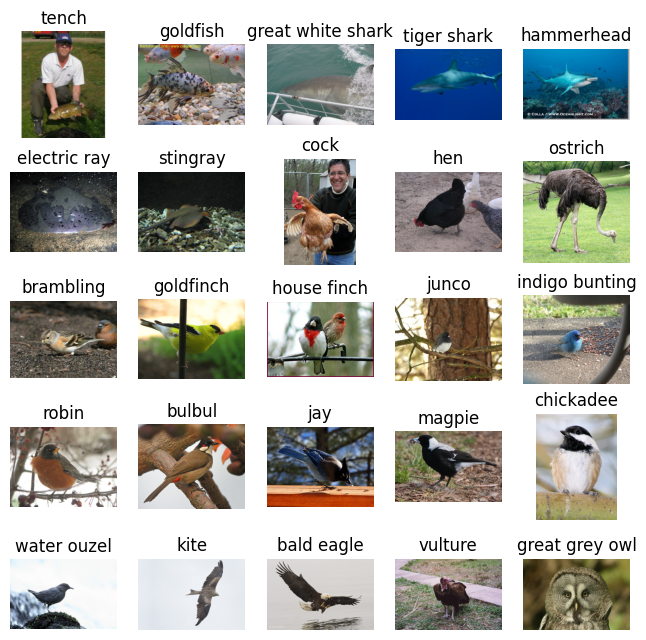

In [8]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img

num_images = 25
sample_images = []
image_classes = []
for cls in os.listdir(image_dir+'train')[:num_images]:
    sample_images.append(glob(f"{image_dir}train/{cls}/*.*")[0])
    image_classes.append(cls)
    
fig, ax = plt.subplots(5, 5)
fig.set_size_inches(8,8)
for ix, a in enumerate(ax.flatten()):
    a.imshow(img.imread(sample_images[ix]))
    a.set_title(class2label[image_classes[ix]].split(',')[0])
    a.axis('off')

In [9]:
from utils import create_answer_box
create_answer_box("Looking at these images, what preprocessing challenges do you see that should concern us when preparing this dataset for training?", "05-01")

Looking at these images, what preprocessing challenges do you see that should concern us when preparing this dataset for training?

Text(value='', layout=Layout(width='500px'), placeholder='Type your answer here')

Button(button_style='success', description='Submit', style=ButtonStyle())

Output()

## [Map-style dataset](https://pytorch.org/docs/stable/data.html)
Use this when you have a well-defined set of samples that you will use to train your model. This is the most common case and the natural choice for ImageNet because we have a well-defined set of images that we want to feed to our model. Let's see how to create a map-style dataset class for ImageNet. 

In [11]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.transforms import transforms
from pathlib import Path

# subclass Dataset
class Imagenet(Dataset):
    
    def __init__(self, root_dir: str, split: str, class2ix: dict, tfms = None):
        """
        The __init__ method is called when creating an instance of the class.
        This is where we set up the dataset, initialize paths, and apply any data transformations.
        
        Args:
            root_dir (str): Full path to the ImageNet CLS-LOC folder containing "train" and "val" subfolders.
            split (str): Specifies which dataset split to use, either "train" or "val".
            class2ix (dict): A dictionary mapping class names to their corresponding indices.
            tfms (callable, optional): A function or transform that takes in a PIL image and returns a transformed version. Defaults to None.
        
        Attributes:
            image_paths (list): A list containing the full paths to all the images in the specified split.
            class2ix (dict): The provided class-to-index mapping dictionary.
        
        Raises:
            AssertionError: If the split is not one of 'train' or 'val'.
        """
        self.root_dir = root_dir
        self.split = split
        self.class2ix = class2ix
        self.tfms = tfms
        
        # make sure split is supported
        assert split in {'train', 'val'}, f"Split must be one of 'train' or 'val', not {split}."
        
        # get a list of all the images
        self.image_paths = list(Path(f"{self.root_dir}/{self.split}").rglob("*.JPEG"))
                                
    def __len__(self):
        """
        Map-style datasets must define the __len__ method. These return the number of 
        samples in the dataset. 
        """
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Map-style datasets must define __getitem__ which takes an index and returns
        a sample. This puts the "map" in "map-style dataset" because it represents
        a mapping from some keys (indices) to the actual data. Map must return 
        a pytorch tensor or numpy array (or a collection thereof).
        """
        # the path to the selected image
        path = self.image_paths[index].as_posix()
        
        # get the class index
        # the class is the next-to-last location in the file path
        y = self.class2ix[path.split('/')[-2]]
        
        # read the instance
        x = read_image(path, mode = ImageReadMode.RGB)
        
        # scale to 0 to 1 range
        x = x / 255
        
        if self.tfms:
            x = self.tfms(x)
        
        # return the image and class
        return x, y
        
tfms = transforms.Compose([
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    transforms.Resize((224,224), antialias=True)
])
        
imagenet = Imagenet('/project/rcde/datasets/imagenet/ILSVRC/Data/CLS-LOC/', split='val', class2ix=class2ix, tfms=tfms)

print("Number of samples:", len(imagenet))
x, y = imagenet[1553]
print("(x.shape, y)=", x.shape, y)

Number of samples: 50000
(x.shape, y)= torch.Size([3, 224, 224]) 31


In [12]:
create_answer_box("The `__getitem__` method does several things: reads image, extracts class from path, applies transforms. Why do we do these operations 'on-the-fly' instead of preprocessing everything upfront?", "05-02")

The `__getitem__` method does several things: reads image, extracts class from path, applies transforms. Why do we do these operations 'on-the-fly' instead of preprocessing everything upfront?

Text(value='', layout=Layout(width='500px'), placeholder='Type your answer here')

Button(button_style='success', description='Submit', style=ButtonStyle())

Output()

## Aside: Mini-Batch Gradient Descent

In the [Regression and Classification notebook](https://clemsonciti.github.io/rcde_workshops/pytorch/02-regression_and_classification.html), we trained the model by computing the loss for the _entire_ dataset multiple times. Our training loop looked something like: 
```python
for i in range(num_epochs):
    # forward pass
    y_hat = model(x)

    # measure the loss
    # this is the mean squared error
    loss = loss_func(y_hat, y)

    # gradient computation
    loss.backward()

    # parameter updates
    optimizer.step()
```

Where `x` and `y` represented the _entire_ input data and target data, respectively. 

---

**Question**: What problems would we run into if we applied this to ImageNet?

---

In most applications of deep learning, we will instead loop over mini-batches (small subsets) of our training data. Our modified training loop will look something like: 
```python
for i in range(num_epochs):
    # Now we have an inner loop over batches of data
    for x_batch, y_batch in batches:
        # forward pass
        y_hat_batch = model(x_batch)

        # measure the loss
        # this is the mean squared error
        loss_batch = loss_func(y_hat_batch, y_batch)

        # gradient computation
        loss_batch.backward()

        # parameter updates
        optimizer.step()
```

Where `batches` is an iterable that returns tuples of the form `(x_batch, y_batch)` representing samples of the full dataset. 

It turns out that using very large batches leads to worse performance. 

<img src="https://github.com/clemsonciti/rcde_workshops/raw/master/pytorch/fig_imagenet_largebatch.png" alt="large batch size" width="500"/>

---

**Question**: Why do you think large batch size leads to worse performance?

---

## Mini-batch gradient descent with the `DataLoader` class

The `Dataset` class is our interface to the individual samples within our dataset. The `DataLoader` utility class provides an interface to batches of data. It also supports multiprocessing out of the box. 

In [15]:
from torch.utils.data import DataLoader

# the DataLoader takes the dataset class as input
# batch_size: how many samples per mini batch
# num_workers: how many parallel processes for data loading
dl = DataLoader(imagenet, batch_size=256, num_workers=8)

print(dl)

Pytorch fetches the batches of data on the fly, so we have to request them one at a time: 

In [16]:
x,y=next(iter(dl)) # get the first batch
print(x.shape, y.shape) 

torch.Size([256, 3, 224, 224]) torch.Size([256])


In [17]:
from utils import create_answer_box
create_answer_box("Concept review! For the four dimensions listed in `x.shape`, what does each dimension represent?", "05-03")

Concept review! For the four dimensions listed in `x.shape`, what does each dimension represent?

Text(value='', layout=Layout(width='500px'), placeholder='Type your answer here')

Button(button_style='success', description='Submit', style=ButtonStyle())

Output()

Notice the new dimension. The dataloader has bundled up the samples into a single tensor. 

We're now ready to write our new training loop:

## ImageNet Training/Testing Loop

In [18]:
# make the datasets
imagenet_train = Imagenet('/project/rcde/datasets/imagenet/ILSVRC/Data/CLS-LOC/', split='train', class2ix=class2ix, tfms=tfms)
imagenet_val = Imagenet('/project/rcde/datasets/imagenet/ILSVRC/Data/CLS-LOC/', split='val', class2ix=class2ix, tfms=tfms)

# create dataloaders for training and validation
dl_train = DataLoader(imagenet_train, batch_size=256, num_workers=9)
dl_val = DataLoader(imagenet_val, batch_size=256, num_workers=9)

---

**Question**: Why is it good to have separate training and validation sets? 

---

In [19]:
import torch

device = torch.device('cuda')

num_epochs=3
# Take a look at `htop` and `nvidia-smi` when running this...
for i in range(num_epochs):
    print(f"[Epoch {i}] Training...")
    for ix, (x,y) in enumerate(dl_train):
        print(f"\r[Epoch {i}] Batch {ix}. x.shape={x.shape}", end='')
        
        # move to device
        x = x.to(device)
        y = y.to(device)
        
        # this is just a test, so break early
        if ix==9:
            break
            
    print(f"\n[Epoch {i}] Testing...")
    for ix, (x, y) in enumerate(dl_val):
        print(f"\r[Epoch {i}] Batch {ix}. x.shape={x.shape}", end='')
        
        # move to device
        x = x.to(device)
        y = y.to(device)
        
        # this is where we put the model evaluation logic
        
        # this is just a test, so break early
        if ix==3:
            break
            
    print()

[Epoch 0] Training...
[Epoch 0] Batch 9. x.shape=torch.Size([256, 3, 224, 224])
[Epoch 0] Testing...
[Epoch 0] Batch 3. x.shape=torch.Size([256, 3, 224, 224])
[Epoch 1] Training...
[Epoch 1] Batch 9. x.shape=torch.Size([256, 3, 224, 224])
[Epoch 1] Testing...
[Epoch 1] Batch 3. x.shape=torch.Size([256, 3, 224, 224])
[Epoch 2] Training...
[Epoch 2] Batch 9. x.shape=torch.Size([256, 3, 224, 224])
[Epoch 2] Testing...
[Epoch 2] Batch 3. x.shape=torch.Size([256, 3, 224, 224])


## Let's actually evaluate a trained model
Training takes too long. 

In [20]:
from torchvision.models import resnet50, ResNet50_Weights

# pretrained weights with advertised accuracy of 80.858% on the validation set
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

In [21]:
dl_val = DataLoader(imagenet_val, batch_size=256, num_workers=9)

preds_ls = []
targs_ls = []

# put the model in eval mode
model.eval()
for ix, (x, y) in enumerate(dl_val):
    
    # move to device
    x = x.to(device)
    y = y.to(device)

    # this is where we put the model evaluation logic
    with torch.no_grad():
        y_pred = model(x)
    
    # compute batch-level performance metrics
    # For classification tasks, the model typically outputs a probability distribution 
    # over the classes for each sample in the batch. 
    # The most likely class is chosen by taking the argmax along the last dimension:
    pred_cls = y_pred.argmax(-1)
    top1_acc = (pred_cls == y).type(torch.float32).mean().item()
    
    # save preds for final acc calc
    preds_ls.append(pred_cls.cpu().squeeze())
    targs_ls.append(y.cpu().squeeze())
    
    print(f"Batch {ix}. Accuracy={100*top1_acc:0.1f}%")

Batch 0. Accuracy=89.8%
Batch 1. Accuracy=87.1%
Batch 2. Accuracy=98.4%
Batch 3. Accuracy=94.9%
Batch 4. Accuracy=93.8%
Batch 5. Accuracy=82.0%
Batch 6. Accuracy=72.3%
Batch 7. Accuracy=79.3%
Batch 8. Accuracy=83.2%
Batch 9. Accuracy=80.1%
Batch 10. Accuracy=78.5%
Batch 11. Accuracy=74.6%
Batch 12. Accuracy=73.8%
Batch 13. Accuracy=78.9%
Batch 14. Accuracy=76.2%
Batch 15. Accuracy=84.4%
Batch 16. Accuracy=91.0%
Batch 17. Accuracy=96.9%
Batch 18. Accuracy=96.5%
Batch 19. Accuracy=86.7%
Batch 20. Accuracy=88.7%
Batch 21. Accuracy=85.9%
Batch 22. Accuracy=91.0%
Batch 23. Accuracy=83.6%
Batch 24. Accuracy=85.5%
Batch 25. Accuracy=94.1%
Batch 26. Accuracy=91.8%
Batch 27. Accuracy=93.8%
Batch 28. Accuracy=96.5%
Batch 29. Accuracy=84.0%
Batch 30. Accuracy=85.5%
Batch 31. Accuracy=80.9%
Batch 32. Accuracy=67.6%
Batch 33. Accuracy=83.6%
Batch 34. Accuracy=88.3%
Batch 35. Accuracy=83.6%
Batch 36. Accuracy=76.6%
Batch 37. Accuracy=76.6%
Batch 38. Accuracy=85.9%
Batch 39. Accuracy=79.7%
Batch 40. 

In [22]:
import numpy as np

preds = torch.concat(preds_ls)
targs = torch.concat(targs_ls)
mean_top1_acc = (preds==targs).type(torch.float32).mean()

print(f"Average Accuracy={100*mean_top1_acc:0.4f}%")

Average Accuracy=80.1540%


In [24]:
(preds==targs).type(torch.float32).std()

tensor(0.3988)